In [1]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import CountVectorizer, IDF, StringIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.pipeline import PipelineModel
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType, IntegerType
from pyspark.sql.functions import udf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc

In [2]:
# Create SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Classification") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "3g") \
    .config("spark.executor.memoryOverhead", "512m") \
    .config("spark.memory.fraction", "0.8")\
    .config("spark.memory.storageFraction", "0.7")\
    .config("spark.driver.maxResultSize", "1g") \
    .getOrCreate()

24/12/11 22:14:23 WARN Utils: Your hostname, hungnd-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/12/11 22:14:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/11 22:14:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read data from hdfs
df = spark.read.parquet("hdfs://localhost:9000/final/cleaned_data/")
df.show()
df.printSchema()

+------+---------+---------------+--------------------+-----------+--------------------+--------------------+--------------------+
|ItemID|Sentiment|SentimentSource|       SentimentText|text_length|               words|      filtered_words|    lemmatized_words|
+------+---------+---------------+--------------------+-----------+--------------------+--------------------+--------------------+
|    62|        1|   Sentiment140|i always get what...|         27|[i, always, get, ...| [always, get, want]| [always, get, want]|
|   194|        1|   Sentiment140|tell  i said happ...|         44|[tell, , i, said,...|[tell, , said, ha...|[tell, , said, ha...|
|   436|        0|   Sentiment140|i hope everyone i...|        136|[i, hope, everyon...|[hope, everyone, ...|[hope, everyone, ...|
|   474|        0|   Sentiment140|all my friends ar...|        101|[all, my, friends...|[friends, gone, h...|[friend, gone, ha...|
|   619|        0|   Sentiment140|bcds closed i gue...|         36|[bcds, closed, i

In [4]:
# Prepare data for model
indexer = StringIndexer(inputCol="Sentiment", outputCol="label")
data = indexer.fit(df).transform(df)

vectorizer = CountVectorizer(inputCol="lemmatized_words", outputCol="raw_features")

idf = IDF(inputCol="raw_features", outputCol="idf")

assembler = VectorAssembler(inputCols=["idf"], outputCol="features")

# Split train/test dataset
train_data, test_data = data.randomSplit([0.9, 0.1], seed=42)

# Metrics
acc_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

In [8]:
# Naive Bayes
nb = NaiveBayes(featuresCol="features", labelCol="label", smoothing=1.0, modelType="multinomial")

pipeline = Pipeline(stages=[vectorizer, idf, assembler, nb])

nb_model = pipeline.fit(train_data)

nb_predictions = nb_model.transform(test_data)

nb_accuracy = acc_evaluator.evaluate(nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")

nb_f1 = f1_evaluator.evaluate(nb_predictions)
print(f"Naive Bayes F1 Score: {nb_f1:.4f}")

24/12/11 19:33:50 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/12/11 19:34:02 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/12/11 19:34:06 WARN DAGScheduler: Broadcasting large task binary with size 20.3 MiB
24/12/11 19:34:23 WARN DAGScheduler: Broadcasting large task binary with size 20.3 MiB
24/12/11 19:34:27 WARN DAGScheduler: Broadcasting large task binary with size 24.3 MiB
24/12/11 19:34:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Naive Bayes Accuracy: 0.7498


24/12/11 19:34:35 WARN DAGScheduler: Broadcasting large task binary with size 24.3 MiB


Naive Bayes F1 Score: 0.7497


In [8]:
#save model to hdfs
nb_model.save("hdfs://localhost:9000/models/nb_sentiment_model")

24/12/10 20:56:31 WARN TaskSetManager: Stage 75 contains a task of very large size (5076 KiB). The maximum recommended task size is 1000 KiB.
24/12/10 20:56:32 WARN TaskSetManager: Stage 79 contains a task of very large size (4189 KiB). The maximum recommended task size is 1000 KiB.
24/12/10 20:56:33 WARN TaskSetManager: Stage 84 contains a task of very large size (4189 KiB). The maximum recommended task size is 1000 KiB.


/home/hungnd/.local/lib/python3.8/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/12/11 19:34:57 WARN DAGScheduler: Broadcasting large task binary with size 24.3 MiB
24/12/11 19:35:00 WARN DAGScheduler: Broadcasting large task binary with size 24.3 MiB
24/12/11 19:35:05 WARN DAGScheduler: Broadcasting large task binary with size 24.3 MiB


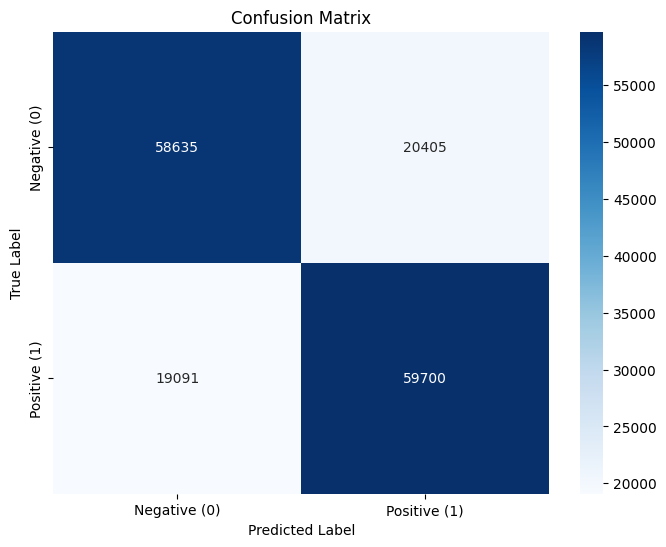

In [9]:
# Confusion Matrix
predictionAndLabels = nb_predictions.select("prediction", "label").rdd.map(lambda row: (float(row[0]), float(row[1])))

metrics = MulticlassMetrics(predictionAndLabels)
cm = metrics.confusionMatrix().toArray()
cm_df = pd.DataFrame(cm, index=["Negative (0)", "Positive (1)"], columns=["Negative (0)", "Positive (1)"])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt=".0f", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [5]:
# Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)
lr_pipeline = Pipeline(stages=[vectorizer, idf, lr])
lr_model = lr_pipeline.fit(train_data)

lr_predictions = lr_model.transform(test_data)

lr_accuracy = acc_evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

lr_f1 = f1_evaluator.evaluate(lr_predictions)
print(f"Logistic Regression F1 Score: {lr_f1:.4f}")

#save model to hdfs
lr_model.save("hdfs://localhost:9000/models/lr_sentiment_model")

24/12/11 20:57:15 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/12/11 20:57:25 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/12/11 20:57:27 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/12/11 20:57:38 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/12/11 20:57:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/11 20:57:40 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/12/11 20:58:50 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/12/11 20:58:54 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/12/11 20:59:53 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/12/11 20:59:56 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/12/11 21:00:56 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/12/11 21:01:00 WARN DAGSchedul

Logistic Regression Accuracy: 0.7649


24/12/11 21:20:16 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


Logistic Regression F1 Score: 0.7649


24/12/11 21:20:22 WARN TaskSetManager: Stage 62 contains a task of very large size (5070 KiB). The maximum recommended task size is 1000 KiB.
24/12/11 21:20:23 WARN TaskSetManager: Stage 66 contains a task of very large size (4189 KiB). The maximum recommended task size is 1000 KiB.
24/12/11 21:20:24 WARN TaskSetManager: Stage 70 contains a task of very large size (2099 KiB). The maximum recommended task size is 1000 KiB.


/home/hungnd/.local/lib/python3.8/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/12/11 21:21:46 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
24/12/11 21:21:47 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
24/12/11 21:21:51 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


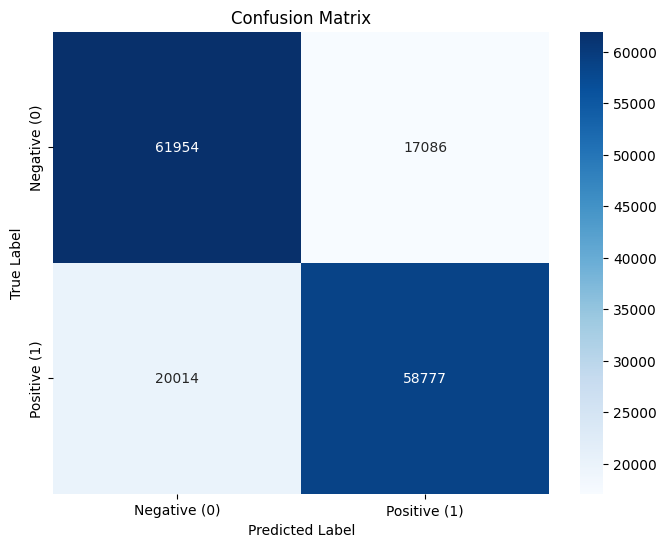

In [6]:
# Confusion Matrix
predictionAndLabels = lr_predictions.select("prediction", "label").rdd.map(lambda row: (float(row[0]), float(row[1])))

metrics = MulticlassMetrics(predictionAndLabels)
cm = metrics.confusionMatrix().toArray()
cm_df = pd.DataFrame(cm, index=["Negative (0)", "Positive (1)"], columns=["Negative (0)", "Positive (1)"])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt=".0f", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=30, maxDepth=5, maxBins=18)

rf_pipeline = Pipeline(stages=[vectorizer, idf, assembler, rf])

rf_model = rf_pipeline.fit(train_data)

rf_predictions = rf_model.transform(test_data)

rf_accuracy = acc_evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

rf_f1 = f1_evaluator.evaluate(rf_predictions)
print(f"Random Forest F1 Score: {rf_f1:.4f}")

In [ ]:
#save model to hdfs
rf_model.save("hdfs://localhost:9000/models/rf_sentiment_model")

In [ ]:
# Load Random forest have trained from hdfs
model = PipelineModel.load("hdfs://localhost:9000/models/rf_sentiment_model")
rf_predictions = model.transform(test_data)

rf_accuracy = acc_evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

rf_f1 = f1_evaluator.evaluate(rf_predictions)
print(f"Random Forest F1 Score: {rf_f1:.4f}")

24/12/11 22:16:31 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


Random Forest Accuracy: 0.6241


24/12/11 22:16:38 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


Random Forest F1 Score: 0.6109


/home/hungnd/.local/lib/python3.8/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/12/11 22:16:47 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/12/11 22:16:48 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/12/11 22:16:52 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


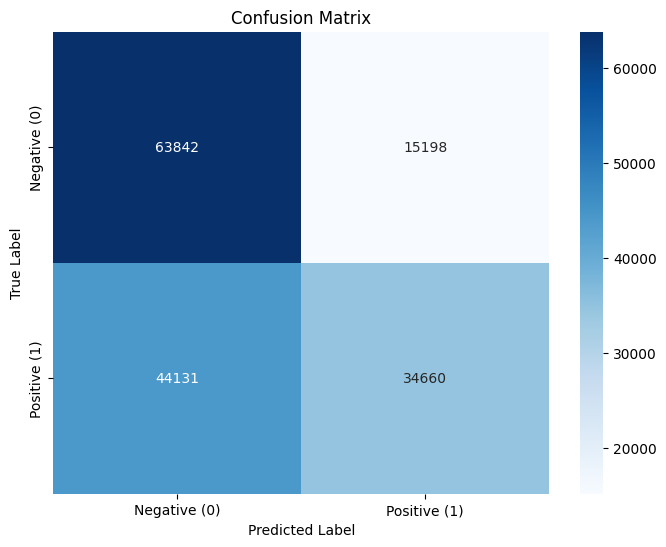

In [7]:
# Confusion Matrix
predictionAndLabels = rf_predictions.select("prediction", "label").rdd.map(lambda row: (float(row[0]), float(row[1])))

metrics = MulticlassMetrics(predictionAndLabels)
cm = metrics.confusionMatrix().toArray()
cm_df = pd.DataFrame(cm, index=["Negative (0)", "Positive (1)"], columns=["Negative (0)", "Positive (1)"])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt=".0f", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()